<a href="https://colab.research.google.com/github/Zatrax110/traffic/blob/main/Traffic_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
Root = "/content/drive/MyDrive/traffic-sign-recognition-and-distance-estimation-main"
os.chdir(Root)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.12.0


# **ASSIGNING LIBRARIES**








In [ ]:
import os
import cv2
import json
import random
import requests
import warnings
import skimage.io
import numpy as np
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
from ast import literal_eval as make_tuple
from google.colab.patches import cv2_imshow

%matplotlib inline
warnings.filterwarnings("ignore")


ASSIGNING PATH FOR DATASET LINKED TO THE GOOGLE DRIVE  

In [ ]:
data_dir = "/content/drive/MyDrive/traffic-sign-recognition-and-distance-estimation-main"



In [ ]:
!wget https://go.vicos.si/dfgaugannot -O annotation_with_augmented.zip
if not os.path.exists('annotation_with_augmented'):
    os.mkdir('annotation_with_augmented')
!unzip annotation_with_augmented.zip -d annotation_with_augmented
!rm annotation_with_augmented.zip

--2023-04-25 17:17:58--  https://go.vicos.si/dfgaugannot
Resolving go.vicos.si (go.vicos.si)... 212.235.189.18
Connecting to go.vicos.si (go.vicos.si)|212.235.189.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://box.vicos.si/skokec/villard/DFG-tsd-aug-annot-json.zip [following]
--2023-04-25 17:17:59--  https://box.vicos.si/skokec/villard/DFG-tsd-aug-annot-json.zip
Resolving box.vicos.si (box.vicos.si)... 212.235.189.20
Connecting to box.vicos.si (box.vicos.si)|212.235.189.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2289025 (2.2M) [application/zip]
Saving to: ‘annotation_with_augmented.zip’

annotation_with_aug 100%[===================>]   2.18M  2.60MB/s    in 0.8s    

2023-04-25 17:18:00 (2.60 MB/s) - ‘annotation_with_augmented.zip’ saved [2289025/2289025]

Archive:  annotation_with_augmented.zip
replace annotation_with_augmented/test.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# **DATA PREPROCESSING**

RESIZING THE ALL THE IMAGES

In [ ]:
# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [ ]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

GIVING ALL THE 43 CLASSES THEIR LABELS RESPECTIVELY

In [ ]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

VISUALIZING THE DATASET

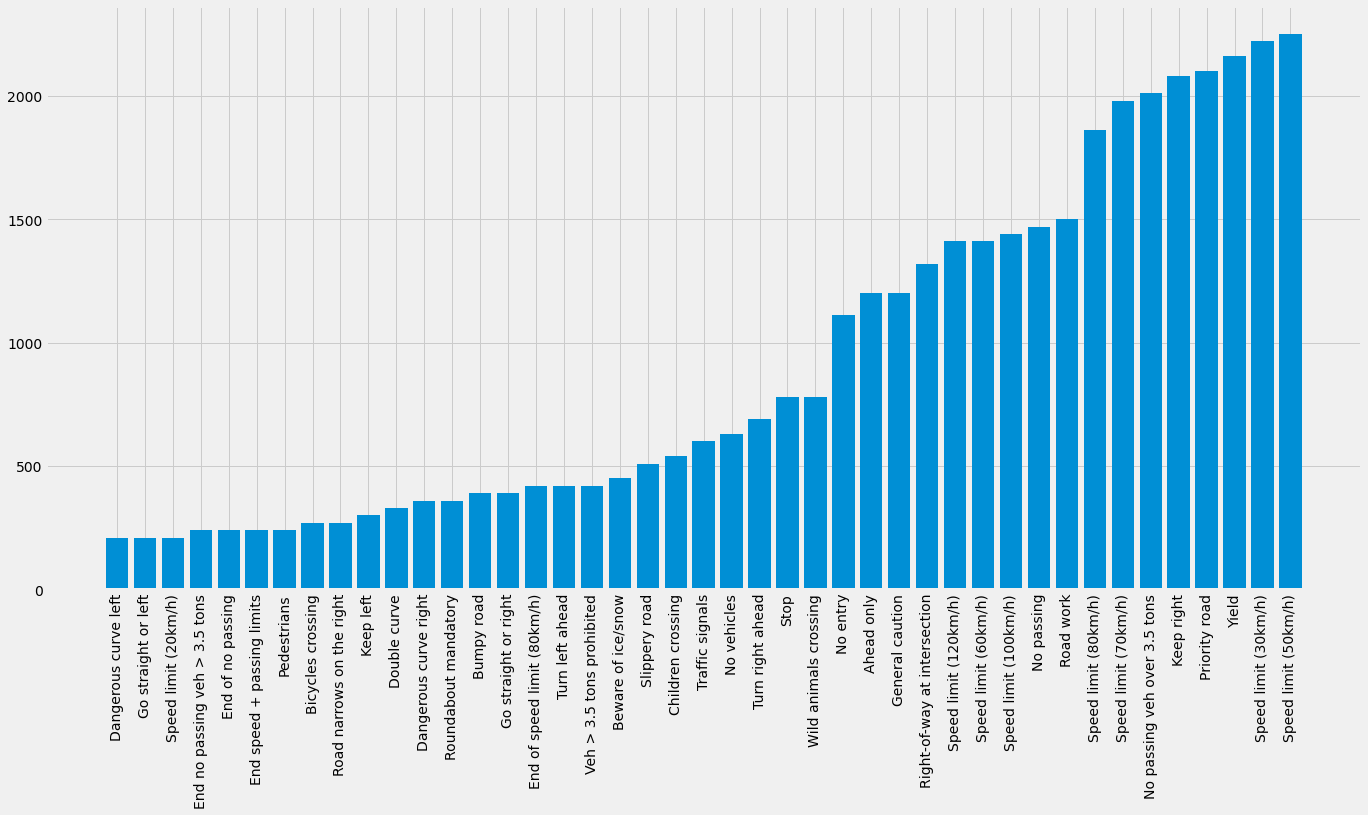

In [ ]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

# Visualizing 25 random images from test data

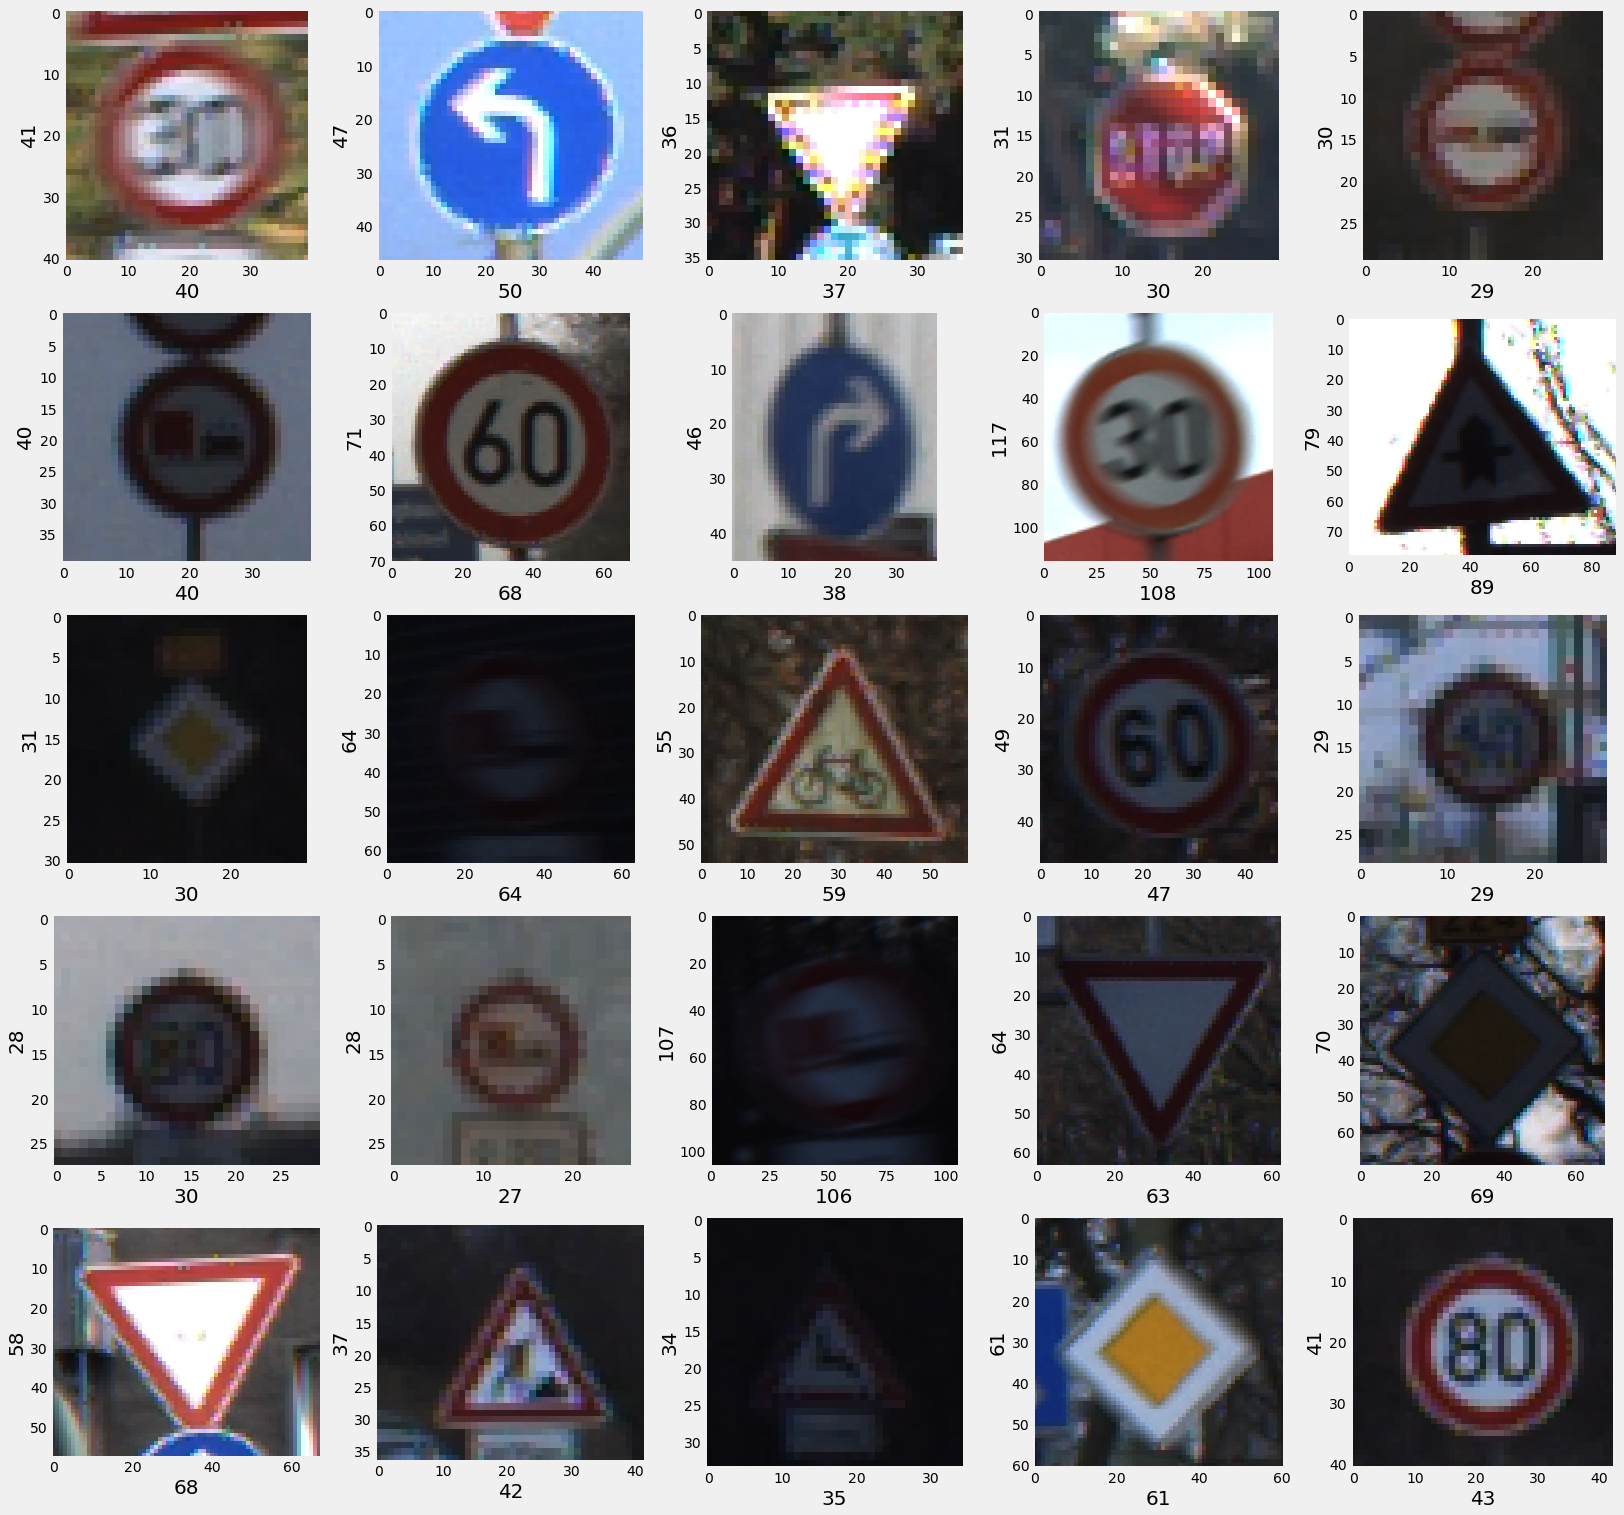

In [ ]:
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

Collecting the Training Data

**Shuffling the training data**

In [ ]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39219, 30, 30, 3) (39219,)


In [ ]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

##Splitting the data into train and validation set


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27453, 30, 30, 3)
X_valid.shape (11766, 30, 30, 3)
y_train.shape (27453,)
y_valid.shape (11766,)


**One hot encoding the labels**

In [ ]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27453, 43)
(11766, 43)


Making the model

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),

    keras.layers.Dense(43, activation='softmax')
])

In [ ]:
learning_rate = 0.01
epochs = 30

opt = Adam(lr=learning_rate, decay=learning_rate / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30
858/858 [==============================] - 83s 95ms/step - loss: 2.3306 - accuracy: 0.4050 - val_loss: 0.8561 - val_accuracy: 0.7392
Epoch 2/30
858/858 [==============================] - 82s 95ms/step - loss: 0.7538 - accuracy: 0.7647 - val_loss: 0.1986 - val_accuracy: 0.9294
Epoch 3/30
858/858 [==============================] - 80s 94ms/step - loss: 0.3718 - accuracy: 0.8832 - val_loss: 0.1120 - val_accuracy: 0.9743
Epoch 4/30
858/858 [==============================] - 81s 94ms/step - loss: 0.2488 - accuracy: 0.9226 - val_loss: 0.0445 - val_accuracy: 0.9873
Epoch 5/30
858/858 [==============================] - 81s 94ms/step - loss: 0.1896 - accuracy: 0.9402 - val_loss: 0.0343 - val_accuracy: 0.9901
Epoch 6/30
858/858 [==============================] - 78s 91ms/step - loss: 0.1585 - accuracy: 0.9516 - val_loss: 0.0358 - val_accuracy: 0.9902
Epoch 7/30
858/858 [==============================] - 80s 93ms/step - loss: 0.1146 - accuracy: 0.9644 - val_loss: 8.6162 - val_accuracy:

In [ ]:
model.save("model.h5")
model.save_weights("/content/drive/MyDrive/Colab_Notebook/TSF/Traffic_sign_classification/output")
dir(aug)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_keras_api_names',
 '_keras_api_names_v1',
 '_validation_split',
 'apply_transform',
 'brightness_range',
 'channel_axis',
 'channel_shift_range',
 'col_axis',
 'cval',
 'data_format',
 'dtype',
 'featurewise_center',
 'featurewise_std_normalization',
 'fill_mode',
 'fit',
 'flow',
 'flow_from_dataframe',
 'flow_from_directory',
 'get_random_transform',
 'height_shift_range',
 'horizontal_flip',
 'interpolation_order',
 'mean',
 'preprocessing_function',
 'random_transform',
 'rescale',
 'rotation_range',
 'row_axis',
 'samplewise_center',
 'samplewise_std_normalization',
 'shear_range',
 'standardize',
 'std',
 'vertica

In [ ]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

pred = model.evaluate(X_test)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)


In [ ]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

In [ ]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()